In [120]:
import sympy as smp
import matplotlib.pyplot as plt
smp.init_printing(use_latex='mathjax')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
from xnp import *
backend = 'cupy' if getattr(np, '__name__', '') == 'cupy' else 'numpy'
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [121]:
#Lets find some entropy

In [122]:
rmax = 1000000000
num = 1000

In [123]:
#lets do a 4d planar BH
d=4
k=0
#placeholders for other vars
# the issue with these guys is that i have absolutely zero clue what "sensible" values would be for these
l=1
q=0

In [267]:
#lets define some functions?
def mu(R,d=d,k=k,l=l,q=q):
    return (R**(d-2))*(k+(q**2)/(R**(2*d-4))+(R**2)/(l**2))
def f(r,R,l=l,q=q,d=d,k=k):
    return k - mu(R)/(r**(d-2)) + (q**2)/(r**(2*d-4)) + (r**2)/(l**2)

def fp(r,R,l=l,q=q,d=d):
    return (d-2)*mu(R,d,k,l,q)/(r**(d-3)) + (4-2*d)*(q**2)/(r**(2*d-5))+ 2*r/(l**2)

def beta(R):
    return 4 * np.pi / fp(R,R)

def gamma2(r0,R):
    return -1*f(r0,R)*(r0**(2*d-4))

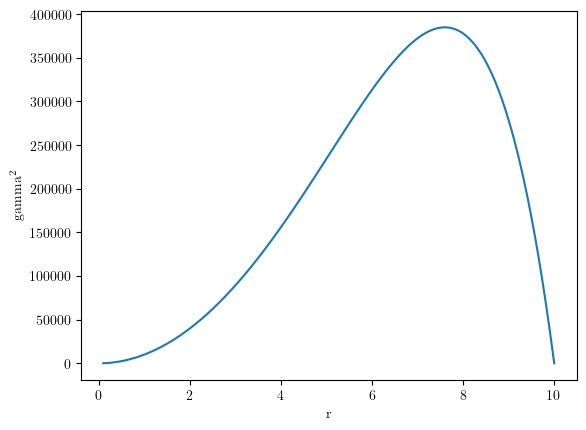

In [268]:
plt.plot(np.linspace(0.1,10,1000).get(),gamma2(np.linspace(0.1,10,1000),10).get())
plt.ylabel(r'gamma$^2$')
plt.xlabel('r')
plt.show()

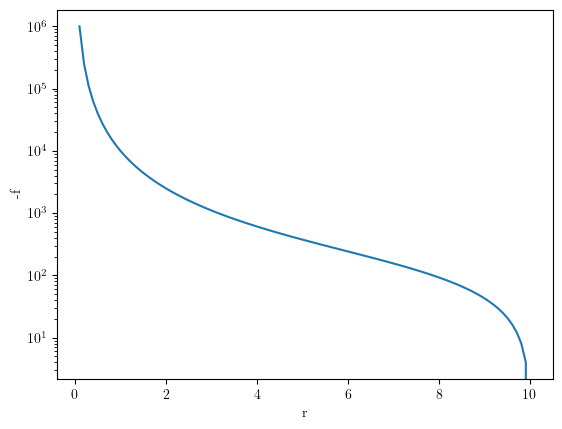

In [269]:
plt.plot(np.linspace(0.1,10,100).get(),-f(np.linspace(0.1,10,100),10).get())
plt.semilogy()
plt.ylabel('-f')
plt.xlabel("r")
plt.show()

In [385]:
#lets get a nice correlation between alpha and r0
# tried to keep this all vectorized, but was getting weird outputs and not the right divergences so its time for for loops (yippee!!!)
def k1(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rbar = 1#R / 2
        rgrid = np.linspace(rbar,r0,num)
        integ = 1/f(rgrid,R)
        mask = ~np.isnan(integ) & np.isfinite(integ)
        sum =  (4 * np.pi / beta(R)) * np.trapz(integ[mask],rgrid[mask])
        list.append(sum)
    return np.array(list)

def k2(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rgrid = np.logspace(np.log10(R+0.001),np.log10(rmax),num)
        integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
        mask = ~np.isnan(integ) & np.isfinite(integ)
        sum = (2*np.pi/beta(R)) * np.trapz(integ[mask],rgrid[mask])
        list.append(sum)
    return np.array(list)

def k3(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rgrid = np.linspace(r0,R-0.1,num)
        integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
        mask = ~np.isnan(integ) & np.isfinite(integ)
        sum = (4*np.pi/beta(R)) * np.trapz(integ[mask],rgrid[mask])
        list.append(sum)
    return np.array(list)

In [386]:
def alpha(r0grid,R):
    return 2*np.exp(k1(r0grid,R)+k2(r0grid,R)+k3(r0grid,R))

In [401]:
#lets get an array relating r0 to alpha for fixed R=10
R = 1
r0grid = np.linspace(0.1,R-0.01,num)
alphagrid = alpha(r0grid,R)

k1grid = k1(r0grid,R)


k2grid = k2(r0grid,R)


k3grid = k3(r0grid,R)



# need to convert from CuPy array to NumPy array, something about being on the GPU.. if this breaks on mac just comment it all out lol
k1grid = k1grid.get()
k2grid = k2grid.get()
k3grid = k3grid.get()
r0grid = r0grid.get()
alphagrid = alphagrid.get()

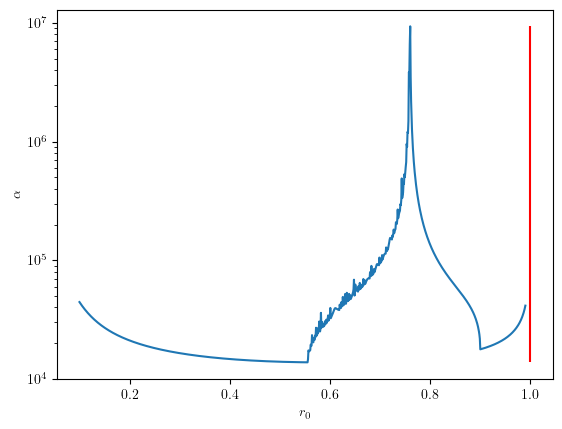

In [400]:
plt.plot(r0grid,alphagrid,label=r'$\alpha$')
plt.xlabel(r'$r_0$')
plt.ylabel(r'$\alpha$')
plt.vlines(R,alphagrid.min(),alphagrid.max(),colors='r',label="Horizon")
plt.semilogy()
# plt.xlim((9,10))
# plt.ylim((1,10))
plt.show()

In [394]:
#now just have to integrate our area functional from inf to R, from R to r0...
#i guess we can just do this a million billion times, varying alpha -> varying r0
#this will be so fun yippee!!!!

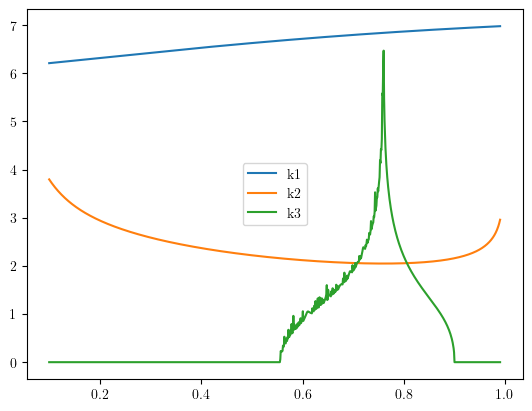

In [395]:
plt.plot(r0grid,k1grid,label='k1')
plt.plot(r0grid,k2grid,label='k2')
plt.plot(r0grid,k3grid,label='k3')
plt.legend()
# plt.semilogx()
# plt.semilogy()


In [396]:
def det(rgrid,R):
    # rough estimate of r_crit in EQ 40 of 1405.7365
    eqgrid = fp(rgrid,R)*rgrid+(2*d-4)*f(rgrid,R)
    print(f'eqgrid: {eqgrid}')
    print(f'abseqgrid: {np.abs(eqgrid)}')
    minloc = np.argmin(np.abs(eqgrid))
    return eqgrid[minloc],rgrid[minloc]

In [397]:
det(np.linspace(0.1,R-0.1,1000000),R)

eqgrid: [-397.94       -397.93359911 -397.92719837 ...    1.92169356    1.92171098
    1.9217284 ]
abseqgrid: [397.94       397.93359911 397.92719837 ...   1.92169356   1.92171098
   1.9217284 ]


(array(3.32074813e-06), array(0.81649672))

In [381]:
# ok so like
# divergences are absolutely NOT what the taylor series in paper would suggest (except for k1 and like the rightmost bit of k2)
# k3 should blow up around 1.41 but certainly does not do that
# 